In [1]:
import pandas as pd
import jsonlines
from tqdm import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Using TensorFlow backend.


In [2]:
#cond_ops = ['=', '>', '<', 'OP']
cond_ops = [[1,0,0], [0,1,0], [0,0,1], 'OP']

In [3]:
#Paths
train_db_path='WikiSQL/data/train.db'
train_data_json_path='WikiSQL/data/train.jsonl'
train_table_json_path='WikiSQL/data/train.tables.jsonl'


dev_db_path='WikiSQL/data/dev.db'
dev_data_json_path='WikiSQL/data/dev.jsonl'
dev_table_json_path='WikiSQL/data/dev.tables.jsonl'

test_db_path='WikiSQL/data/test.db'
test_data_json_path='WikiSQL/data/test.jsonl'
test_table_json_path='WikiSQL/data/test.tables.jsonl'

In [4]:
def get_col_tokens(table_json_path):
    tokens=[]
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            for header in obj['header']:
                tokens.append(header)
    return tokens

In [5]:
def get_question_tokens(data_json_path):
    tokens=[]
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            tokens.append(obj['question'])
    return tokens

In [6]:
texts=[]
texts.extend(get_col_tokens(train_table_json_path))
texts.extend(get_col_tokens(dev_table_json_path))
texts.extend(get_col_tokens(test_table_json_path))

18585it [00:00, 34110.12it/s]
2716it [00:00, 37802.57it/s]
5230it [00:00, 36549.69it/s]


In [7]:
texts.extend(get_question_tokens(train_data_json_path))
texts.extend(get_question_tokens(dev_data_json_path))
texts.extend(get_question_tokens(test_data_json_path))

56355it [00:00, 159043.95it/s]
8421it [00:00, 121458.85it/s]
15878it [00:00, 154876.03it/s]


In [8]:
tokenizer=Tokenizer(char_level=True,lower=True)
tokenizer.fit_on_texts(texts)

In [9]:
max_token_index=len(tokenizer.index_word.keys())+1
max_token_index

1246

In [10]:
def text2seq(text):
    return np.ravel([tokenizer.texts_to_sequences([text])])

In [11]:
max_len=0
for text in texts:
    if len(text2seq(text))>max_len:
        max_len=len(text2seq(text))
max_len

419

In [12]:
def text2seq(text):
    return np.ravel(pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=max_len,padding='post'))

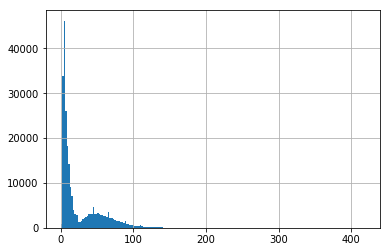

In [13]:
df = pd.Series(texts)
df.str.len().hist(bins=200)
plt.show()

In [14]:
del texts

In [15]:
#make a dict to keep track of all the columns of all the tables
def get_table(table_json_path):
    tables={}
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            tables[obj['id']]={'headers':[],'types':[]}
            tables[obj['id']]['headers']=obj['header']
            tables[obj['id']]['types']=obj['types']
    return tables

In [16]:
train_tables=get_table(train_table_json_path)
dev_tables=get_table(dev_table_json_path)
test_tables=get_table(test_table_json_path)

18585it [00:00, 33975.44it/s]
2716it [00:00, 37165.81it/s]
5230it [00:00, 36938.66it/s]


In [17]:
def get_where_cols_value(dict_obj,tables):
    temp=tables[dict_obj['table_id']]['headers']
    where_cols = []
    values=[]
    ops=[]
    for cond in dict_obj['sql']['conds']:
        where_cols.append(temp[cond[0]])
        value=str(cond[2]).lower()
        start=dict_obj['question'].lower().find(value)
        end=start+len(value)
        values.append((start,end))
        ops.append(cond_ops[cond[1]])
    return where_cols,values,ops
    

In [18]:
def get_dataset(data_json_path,table):
    #read the jsonl file
    X=[]
    y=[]
    global tokenizer
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            where_cols,values,ops=get_where_cols_value(obj,table)
            question=obj['question']
            
    
            #tokenized representation
            question=text2seq(question)
            for i in range(len(where_cols)):
                
                X.append([question,text2seq(where_cols[i]),ops[i]])
                y.append(values[i])
            
    return X,y

In [19]:
X_train,y_train=get_dataset(train_data_json_path,train_tables)

56355it [00:05, 10066.10it/s]


In [20]:
X_dev,y_dev=get_dataset(dev_data_json_path,dev_tables)

8421it [00:00, 8534.67it/s]


In [21]:
#dimension
d=64
from keras.models import Model
from keras.layers import Input, GRU, Dense ,Flatten , Concatenate,Bidirectional,Average,RepeatVector,Flatten
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm
from keras import regularizers

In [23]:
# Define an input sequence and process it.
question_input = Input(shape=(max_len,),name='Q_input')
column_input = Input(shape=(max_len,),name='C_input')
ops_input = Input(shape=(3,),name='Ops_input')

embedding= Embedding(max_token_index, d, input_length=max_len,name='embedding')
# embedding_C= Embedding(max_token_index, d, input_length=max_len,name='embedding_C')
#                      embeddings_constraint=max_norm(2.),
#                      embeddings_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))

Q_embedding= embedding(question_input)
C_embedding= embedding(column_input)



encoder_question = Bidirectional(GRU(d, return_state=True))
Q_act , Q_state_h1, Q_state_h2 = encoder_question(Q_embedding)

encoder_column = Bidirectional(GRU(d, return_state=True))
C_act , C_state_h1, C_state_h2 = encoder_column(C_embedding)


con=Concatenate()([Q_act,Q_state_h1,Q_state_h2,C_act,C_state_h1,C_state_h2,ops_input])


start=Dense(max_len,activation='softmax',name='start')(con)

con_2=Concatenate()([con,start])

end=Dense(max_len,activation='softmax',name='end')(con_2)

model = Model([question_input, column_input,ops_input], [start,end])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Q_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
C_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 419, 64)      79744       Q_input[0][0]                    
                                                                 C_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 128), (None, 49536       embedding[0][0]                  
__________

In [24]:
#from sklearn.externals import joblib

#wb=joblib.load('embedding select col.joblib')
#model.layers[2].set_weights(wb)
#model.layers[2].trainable = False

In [25]:
import keras_contrib

from keras import optimizers

opt = optimizers.Adam(lr=0.0001)

In [26]:
opt=keras_contrib.optimizers.padam.Padam()

In [27]:
# Run training
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [28]:
def generator(X,y,batch_size=32):
    indices=range(len(X))
    while True:
        # Select files (paths/indices) for the batch
        batch_indices= np.random.choice(a = indices,size = batch_size)
        X_Q_batch=[]
        X_C_batch=[]
        X_O_batch=[]
        y_start_batch=[]
        y_end_batch=[]
        
        for index in batch_indices:
            X_Q_batch.append(X[index][0])
            X_C_batch.append(X[index][1])
            X_O_batch.append(X[index][2])
            y_start_batch.append(np.eye(max_len)[y[index][0]])
            y_end_batch.append(np.eye(max_len)[y[index][1]])
        yield( [np.array(X_Q_batch),np.array(X_C_batch),np.array(X_O_batch)], [np.array(y_start_batch),np.array(y_end_batch)])
            

In [29]:
batch_size = 128  # Batch size for training.
epochs = 200  # Number of epochs to train for.
train_generator=generator(X_train,y_train,batch_size=batch_size)
dev_generator=generator(X_dev,y_dev,batch_size=batch_size)

In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=15),
             ModelCheckpoint(filepath='where_value_best_model.h5', monitor='val_loss', save_best_only=True)]

In [31]:
train_steps=len(X_train)/batch_size
dev_steps=len(X_dev)/batch_size

In [33]:
model.load_weights('where_value_best_model.h5')

In [104]:
history=model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, verbose=1,
                            callbacks=callbacks, validation_data=dev_generator,
                            validation_steps=dev_steps,max_queue_size=10)

Epoch 1/200
600/599 [==============================] - 495s 825ms/step - loss: 3.5138 - start_loss: 1.5779 - end_loss: 1.9359 - start_acc: 0.5992 - end_acc: 0.5112 - val_loss: 4.4390 - val_start_loss: 2.0401 - val_end_loss: 2.3989 - val_start_acc: 0.5134 - val_end_acc: 0.4293
Epoch 2/200
600/599 [==============================] - 494s 823ms/step - loss: 3.3801 - start_loss: 1.5141 - end_loss: 1.8660 - start_acc: 0.6186 - end_acc: 0.5357 - val_loss: 4.3011 - val_start_loss: 1.9590 - val_end_loss: 2.3421 - val_start_acc: 0.5206 - val_end_acc: 0.4408
Epoch 3/200
600/599 [==============================] - 494s 824ms/step - loss: 3.3037 - start_loss: 1.4817 - end_loss: 1.8220 - start_acc: 0.6286 - end_acc: 0.5504 - val_loss: 4.3439 - val_start_loss: 1.9887 - val_end_loss: 2.3552 - val_start_acc: 0.5139 - val_end_acc: 0.4384
Epoch 4/200
600/599 [==============================] - 494s 824ms/step - loss: 3.2765 - start_loss: 1.4651 - end_loss: 1.8114 - start_acc: 0.6336 - end_acc: 0.5534 - val

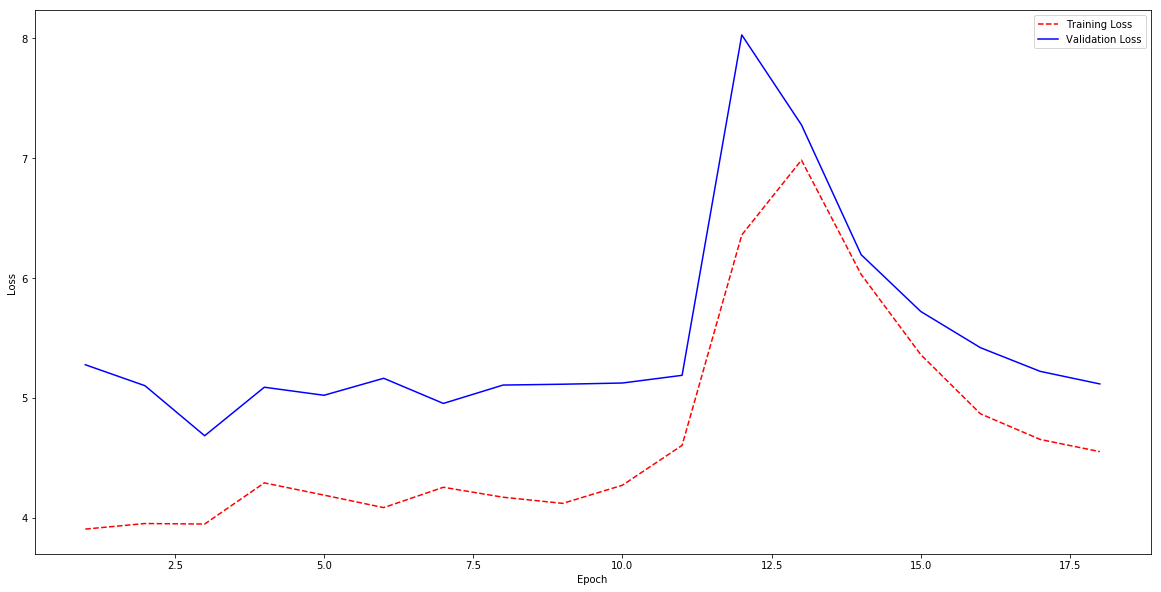

In [82]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [35]:
X_test,y_test=get_dataset(test_data_json_path,test_tables)

15878it [00:01, 10511.58it/s]


In [36]:
test_generator=generator(X_test,y_test,batch_size=batch_size)
test_steps=len(X_test)/batch_size

In [39]:
model.evaluate_generator(dev_generator, steps=dev_steps, verbose=1)

91/90 [==============================] - 38s 413ms/step


[3.733716597923866,
 1.7507181062803163,
 1.982998489023565,
 0.5792410714285714,
 0.529790521978022]

In [38]:
model.evaluate_generator(test_generator, steps=test_steps, verbose=1)

171/170 [==============================] - 71s 416ms/step


[3.7847146876374183,
 1.7848072198399327,
 1.9999074712831375,
 0.5723227339181286,
 0.5256304824561403]